<a href="https://colab.research.google.com/github/pankajrawat9075/CS6910_assignment_3/blob/main/DL_PA3_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries and models

In [ ]:
%%capture
!pip install wandb

In [ ]:
import wandb

In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [ ]:
print(device)

cuda


## Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {'#': 0, '$': 1, '^': 2}
        self.char2count = {'#': 1, '$': 1, '^': 1}
        self.index2char = {0: '#', 1: '$', 2: '^'}
        self.n_chars = 3  # Count
        self.data = {}
        

    def addWord(self, word):
        for char in word:
            self.addChar(char)

    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

    


In [ ]:
# return max length of input and output words
def maxLength(data):
    ip_mlen, op_mlen = 0, 0

    for i in range(len(data)):
        input = data[0][i]
        output = data[1][i]
        if(len(input)>ip_mlen):
            ip_mlen=len(input)

        if(len(output)>op_mlen):
            op_mlen=len(output)

    return ip_mlen, op_mlen

In [ ]:
import numpy
input_shape = 0
from torch.utils.data import TensorDataset, DataLoader
def preprocess(data, input_lang, output_lang):
    maxlenInput, maxlenOutput = maxLength(data)
    # we use maxlenInput as 26 since it is the maximum of all input len
    maxlenInput = 26
    input = numpy.zeros((len(data), maxlenInput + 1))
    output = numpy.zeros((len(data), maxlenOutput + 2))
    maxlenInput, maxlenOutput = maxLength(data)
    unknown = input_lang.char2index['$']

    for i in range(len(data)):
        op = '^' + data[1][i]
        ip = data[0][i].ljust(maxlenInput + 1, '#')
        op = op.ljust(maxlenOutput + 2, '#')
        

        for index, char in enumerate(ip):
            if input_lang.char2index.get(char) is not None:
                input[i][index] = input_lang.char2index[char]
            else:
                input[i][index] = unknown
        

        
        for index, char in enumerate(op):
            if output_lang.char2index.get(char) is not None:
                output[i][index] = output_lang.char2index[char]
            else:
                output[i][index] = unknown  

    print(input.shape)
    print(output.shape)

    return TensorDataset(torch.from_numpy(input), torch.from_numpy(output))

In [ ]:
def loadData(lang):
    train_df = pd.read_csv(f"drive/MyDrive/aksharantar_sampled/{lang}/{lang}_train.csv", header = None)
    val_df = pd.read_csv(f"drive/MyDrive/aksharantar_sampled/{lang}/{lang}_valid.csv", header = None)
    test_df = pd.read_csv(f"drive/MyDrive/aksharantar_sampled/{lang}/{lang}_test.csv", header = None)

    input_lang = Lang('eng')
    output_lang = Lang(lang)
    
    # add the words to the respective languages
    for i in range(len(train_df)):
        
        input_lang.addWord(train_df[0][i])
        output_lang.addWord(train_df[1][i])

    # print(input_lang.char2index)
    # print(input_lang.index2char)
    trainDataset = preprocess(train_df, input_lang, output_lang)
    testDataset = preprocess(test_df, input_lang, output_lang)
    valDataset = preprocess(val_df, input_lang, output_lang)

    return trainDataset, testDataset, valDataset, input_lang, output_lang


trainData, testData, valData, ipLang, opLang = loadData('hin')


(51200, 27)
(51200, 22)
(4096, 27)
(4096, 22)
(4096, 27)
(4096, 22)


In [ ]:
wandb.login(key ="")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# seq2seq model

## Encoder

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, embedding_size, # input_size is size of input language dictionary
                 num_layers, cell_type,
                  bidirectional, dropout, batch_size) :
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size  # size of an hidden state representation
        self.num_layers = num_layers   
        self.bidirectional = True if bidirectional == 'Yes' else False
        self.batch_size = batch_size
        self.cell_type = cell_type
        self.embedding_size=embedding_size

        # this adds the embedding layer
        self.embedding = nn.Embedding(num_embeddings=input_size,embedding_dim= embedding_size)
        self.dropout = nn.Dropout(dropout)

        # this adds the Neural Network layer for the encoder
        if self.cell_type == "GRU":
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional, dropout=dropout)
        elif self.cell_type == "LSTM":
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional, dropout=dropout)
        else:
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers=num_layers, bidirectional=self.bidirectional, dropout=dropout)

    def forward(self, input, hidden): # input shape (seq_len, batch_size) hidden shape tuple for lstm, otherwise single
        embedded = self.embedding(input.long()).view(-1,self.batch_size, self.embedding_size)
        output = self.dropout(embedded) # output shape (seq_len, batch_size, embedding size)

        output, hidden = self.rnn(output, hidden) # for LSTM hidden is a tuple
        if self.bidirectional:
            if self.cell_type == "LSTM":
                hidden_state = hidden[0].resize(2,self.num_layers,self.batch_size,self.hidden_size)
                cell_state = hidden[1].resize(2,self.num_layers,self.batch_size,self.hidden_size)
                hidden = (torch.add(hidden_state[0],hidden_state[1])/2, torch.add(cell_state[0],cell_state[1])/2)
            else:
                hidden=hidden.resize(2,self.num_layers,self.batch_size,self.hidden_size)
                hidden=torch.add(hidden[0],hidden[1])/2
            
            split_tensor= torch.split(output, self.hidden_size, dim=-1)
            output=torch.add(split_tensor[0],split_tensor[1])/2
        return output, hidden

    # initializing the initial hidden state for the encoder
    def initHidden(self):
        num_directions = 2 if self.bidirectional else 1
        if self.cell_type == "LSTM":
            return (torch.zeros(self.num_layers * num_directions, self.batch_size, self.hidden_size, device=device),
                    torch.zeros(self.num_layers * num_directions, self.batch_size, self.hidden_size, device=device))
        else:
            return torch.zeros(self.num_layers * num_directions, self.batch_size, self.hidden_size, device=device)


## Decoder

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size, num_layers, # output size is the size of output language dictionary
                 cell_type, dropout, batch_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type.lower()
        self.batch_size = batch_size
        self.embedding_size=embedding_size

        self.embedding = nn.Embedding(output_size, embedding_size)
        # self.dropout = nn.Dropout(dropout)
        
        if self.cell_type == "gru":
            self.rnn = nn.GRU(embedding_size, hidden_size, num_layers=num_layers)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(embedding_size, hidden_size, num_layers=num_layers)
        else:
            self.rnn = nn.RNN(embedding_size, hidden_size, num_layers=num_layers)

        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden): # input shape (1, batch_size)
        embedded = self.embedding(input.long()).view(-1, self.batch_size, self.embedding_size)
        # # shape (1, batch_size, embedding_size)
        output = F.relu(embedded)
        output, hidden = self.rnn(output, hidden) # output shape (1, batch_size, hidden_size)
        output = self.softmax(self.out(output)) # shape (1, batch_size, output_size)
        return output, hidden

    # not needed since hidden will be provided by the encoder

## Attention Decoder

In [ ]:
class AttentionDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, embedding_size, num_layers,
                 cell_type, dropout, batch_size, max_length):
        super(AttentionDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        self.batch_size = batch_size
        self.embedding_size = embedding_size
        self.max_length = max_length
        self.dropout = dropout

        self.embedding = nn.Embedding(output_size, embedding_size)
        self.dropout = nn.Dropout(self.dropout)
        self.attention = nn.Linear(hidden_size + embedding_size, self.max_length)
        self.attention_combine = nn.Linear(hidden_size + embedding_size, hidden_size)

        if self.cell_type == "GRU":
            self.rnn = nn.GRU(hidden_size, hidden_size, num_layers=num_layers)
        elif self.cell_type == "LSTM":
            self.rnn = nn.LSTM(hidden_size, hidden_size, num_layers=num_layers)
        else:
            self.rnn = nn.RNN(hidden_size, hidden_size, num_layers=num_layers)

        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden, encoder_outputs): #input shape (1, batch_size)
        embedded = self.embedding(input.long()).view(-1, self.batch_size, self.embedding_size) 
        # embedded shape (1, batch_size, embedding_size)
        embedded = F.relu(embedded)

        # Compute attention scores
        if self.cell_type == "LSTM":
            attn_hidden = torch.mean(hidden[0], dim=0)
        else:
            attn_hidden = torch.mean(hidden, dim = 0)
        attn_scores = self.attention(torch.cat((embedded, attn_hidden.unsqueeze(0)), dim=2)) # attn_scores shape (1, batch_size, max_length)
        
        attn_weights = F.softmax(attn_scores, dim=-1)  # attn_scores shape (1, 16, 25)
        

        # Apply attention weights to encoder outputs
        attn_applied = torch.bmm(attn_weights.transpose(0, 1), encoder_outputs.transpose(0, 1))
        
        # Combine attention output and embedded input
        combined = torch.cat((embedded, attn_applied.transpose(0, 1)), dim=2)
        combined = self.attention_combine(combined)
        combined = F.relu(combined) # shape (1, batch_size, hidden_size)

        # Run through the RNN
        output, hidden = self.rnn(combined, hidden)
        # output shape: (1, batch_size, hidden_size)

        # Pass through linear layer and softmax activation
        output = self.out(output)  # shape: (1, batch_size, output_size)
        output = self.softmax(output)
        return output, hidden, attn_weights.transpose(0, 1)


# Helper functions

## count matches

In [ ]:
def count_exact_matches(pred, target):
    """
    Counts the number of rows in preds tensor that match exactly with each row in y tensor.
    pred: tensor of shape (batch_size, seq_len-1)
    y: tensor of shape (batch_size, seq_len-1)
    """
    
    count=0;
    for i in range(pred.shape[0]):
      flag = True
      for j in range(pred.shape[1]):
        if(target[i][j]!=pred[i][j]):
          flag=False
          break;
         
      if(flag):
        count+=1;
    
    return count

## evaluation

In [ ]:
def evaluate(data,encoder, decoder,output_size,batch_size,hidden_size,num_layers_encoder,num_layers_decoder, cell_type, attention):
    


    running_loss = 0
    correct =0
    
    loader = DataLoader(data, batch_size=batch_size)
    loss_fun = nn.CrossEntropyLoss(reduction="sum")
    seq_len = 0

    atten_weights = torch.zeros(1,21, 27).to(device) # required to return the attention weights
    predictions = torch.zeros(22-1, 1).to(device)
    with torch.no_grad():
      for j,(x,y) in enumerate(loader):
        loss=0
        encoder.eval()
        decoder.eval()

        x = x.to(device)
        y = y.to(device)

        x = x.T
        y = y.T
        seq_len = len(y)
        
        encoder_hidden=encoder.initHidden()
        encoder_output,encoder_hidden = encoder(x,encoder_hidden)
        
        
        decoder_input =y[0]
        
        # Handle different numbers of layers in the encoder and decoder
        if num_layers_encoder != num_layers_decoder:
            if num_layers_encoder < num_layers_decoder:
                remaining_layers = num_layers_decoder - num_layers_encoder

                # Copy all encoder hidden layers and then repeat the top layer
                if cell_type == "LSTM":
                    top_layer_hidden = (encoder_hidden[0][-1].unsqueeze(0), encoder_hidden[1][-1].unsqueeze(0))
                    extra_hidden = (top_layer_hidden[0].repeat(remaining_layers, 1, 1), top_layer_hidden[1].repeat(remaining_layers, 1, 1))
                    decoder_hidden = (torch.cat((encoder_hidden[0], extra_hidden[0]), dim=0), torch.cat((encoder_hidden[1], extra_hidden[1]), dim=0))
                else:
                    top_layer_hidden = encoder_hidden[-1].unsqueeze(0) #top_layer_hidden shape (1, batch_size, hidden_size)
                    extra_hidden = top_layer_hidden.repeat(remaining_layers, 1, 1)
                    decoder_hidden = torch.cat((encoder_hidden, extra_hidden), dim=0)

            else:
                # Slice the hidden states of the encoder to match the decoder layers
                if cell_type == "LSTM":
                    decoder_hidden = (encoder_hidden[0][-num_layers_decoder:], encoder_hidden[1][-num_layers_decoder:])
                else :
                    decoder_hidden = encoder_hidden[-num_layers_decoder:]
        else:
            decoder_hidden = encoder_hidden

        pred=torch.zeros(len(y)-1, batch_size).to(device)
        atten_weight_default = torch.zeros(batch_size,1, 27).to(device)
        for k in range(1,len(y)):
          if attention == "Yes":
              
              decoder_output, decoder_hidden, atten_weight = decoder(decoder_input, decoder_hidden, encoder_output)
              atten_weight_default = torch.cat((atten_weight_default, atten_weight), dim = 1)
          else:
              decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden)
          max_prob, index = decoder_output.topk(1) # max_prob shape (1, batch_size, 1)
          decoder_output = torch.squeeze(decoder_output)
          loss += loss_fun(decoder_output, y[k].long())
          pred[k-1]= torch.squeeze(index)
          decoder_input = index
        if attention == "Yes":
            atten_weights = torch.cat((atten_weights, atten_weight_default[:, 1:, :]), dim = 0)

        running_loss += loss.item()
        correct += count_exact_matches(pred.T,y[1:,:].T)
        predictions = torch.cat((predictions, pred), dim=1)

        
    avg_loss = running_loss / (len(data) * seq_len)
    print("correct =", correct)
    avg_acc = 100 * (correct / (len(data)))
    if attention == "Yes":
        return avg_loss, avg_acc, predictions, atten_weights[1:, :, :]
    else:
        return avg_loss, avg_acc, predictions
            
   
 

# Training function

In [ ]:
def train(sweeps = True, test = False):

    if sweeps == False: 
        configs = config_defaults  # use the default configuration which has the best hyperparameters
    else:
        wandb.init(config= config_defaults, project='DL_assign_3')   # if not test then run wandb sweeps
        configs=wandb.config
       

    learn_rate = configs['learn_rate']
    batch_size = configs['batch_size']
    hidden_size = configs['hidden_size']
    embedding_size = configs['embedding_size']
    num_layers_encoder = configs['num_layers_encoder']
    num_layers_decoder = configs['num_layers_decoder']
    cell_type = configs['cell_type']
    bidirectional = configs['bidirectional']
    dropout = configs['dropout']
    teach_ratio = configs['teach_ratio']
    epochs = configs['epochs']
    attention = configs['attention']

    if sweeps:
       wandb.run.name='hidden_'+str(hidden_size)+'_batch_'+str(batch_size)+'_embed_size_'+str(embedding_size)+'_dropout_'+str(dropout)+'_cell_'+str(cell_type)

    input_len = ipLang.n_chars
    output_len = opLang.n_chars
    
    encoder = EncoderRNN(input_len, hidden_size, embedding_size, 
                 num_layers_encoder, cell_type,
                  bidirectional, dropout, batch_size)
    
    if attention =="Yes":
        decoder = AttentionDecoderRNN(hidden_size, output_len, embedding_size, num_layers_decoder, 
                 cell_type, dropout, batch_size, 27)
    else:
        decoder = DecoderRNN(hidden_size, output_len, embedding_size, num_layers_decoder, 
                 cell_type, dropout, batch_size)#dropout not used
    
    train_loader = DataLoader(trainData, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valData, batch_size=batch_size, shuffle=True)

    encoder_optimizer=optim.Adam(encoder.parameters(),learn_rate)
    decoder_optimizer=optim.Adam(decoder.parameters(),learn_rate)
    loss_fun=nn.CrossEntropyLoss(reduction="sum")

    encoder.to(device)
    decoder.to(device)
    seq_len = 0

    # Initialize variables for early stopping
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0

    for i in range(epochs):
        
        running_loss = 0.0
        train_correct = 0

        encoder.train()
        decoder.train()

        for j,(train_x,train_y) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_y = train_y.to(device)

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            train_x=train_x.T
            train_y=train_y.T
            # print("train_x.shapetrain_x.shape)
            seq_len = len(train_y)
            encoder_hidden=encoder.initHidden()
            # for LSTM encoder_hidden shape ((num_layers * num_directions, batch_size,hidden_size),(self.num_layers * num_directions, batch_size, hidden_size))
            encoder_output,encoder_hidden = encoder(train_x,encoder_hidden)
            # encoder_hidden shape (num_layers, batch_size, hidden_size)
            
            
            # lets move to the decoder
            decoder_input = train_y[0] # shape (1, batch_size)
           
            # Handle different numbers of layers in the encoder and decoder
            if num_layers_encoder != num_layers_decoder:
                if num_layers_encoder < num_layers_decoder:
                    remaining_layers = num_layers_decoder - num_layers_encoder
                    # Copy all encoder hidden layers and then repeat the top layer
                    if cell_type == "LSTM":
                        top_layer_hidden = (encoder_hidden[0][-1].unsqueeze(0), encoder_hidden[1][-1].unsqueeze(0))
                        extra_hidden = (top_layer_hidden[0].repeat(remaining_layers, 1, 1), top_layer_hidden[1].repeat(remaining_layers, 1, 1))
                        decoder_hidden = (torch.cat((encoder_hidden[0], extra_hidden[0]), dim=0), torch.cat((encoder_hidden[1], extra_hidden[1]), dim=0))
                    else:
                        top_layer_hidden = encoder_hidden[-1].unsqueeze(0) #top_layer_hidden shape (1, batch_size, hidden_size)
                        extra_hidden = top_layer_hidden.repeat(remaining_layers, 1, 1)
                        decoder_hidden = torch.cat((encoder_hidden, extra_hidden), dim=0)
  
                else:
                    # Slice the hidden states of the encoder to match the decoder layers
                    if cell_type == "LSTM":
                        decoder_hidden = (encoder_hidden[0][-num_layers_decoder:], encoder_hidden[1][-num_layers_decoder:])
                    else :
                        decoder_hidden = encoder_hidden[-num_layers_decoder:]
            else:
                decoder_hidden = encoder_hidden
            
            loss = 0
            correct = 0
           
            for k in range(0, len(train_y)-1):
                
                if attention == "Yes":
                    decoder_output, decoder_hidden, atten_weights = decoder(decoder_input, decoder_hidden, encoder_output)
                else:
                    decoder_output, decoder_hidden= decoder(decoder_input, decoder_hidden) # decoder_output shape (1, batch_size, output_size)

                max_prob, index = decoder_output.topk(1) # max_prob shape (1, batch_size, 1)
                index = torch.squeeze(index) # shape (batch_size)
                decoder_output = torch.squeeze(decoder_output)
                loss += loss_fun(decoder_output, train_y[k+1].long())
                
                correct += (index == train_y[k+1]).sum().item()

                # Apply teacher forcing
                use_teacher_forcing = True if random.random() < teach_ratio else False

                if use_teacher_forcing:
                    decoder_input = train_y[k+1]
                
                else:
                    decoder_input = index

            running_loss += loss.item()
            train_correct += correct
            loss.backward()
            encoder_optimizer.step()
            decoder_optimizer.step()
        

        # find train loss and accuracy and print + log to wandb
        if attention == "Yes":
            _, train_accuracy,_, _ = evaluate(trainData,encoder, decoder,output_len,batch_size,hidden_size,num_layers_encoder,num_layers_decoder, cell_type, attention)
        else:
            _, train_accuracy,_= evaluate(trainData,encoder, decoder,output_len,batch_size,hidden_size,num_layers_encoder,num_layers_decoder, cell_type, attention)
        
        print(f"epoch {i}, training loss {running_loss/(len(trainData)* seq_len)}, training accuracy {train_accuracy}")
        if sweeps:
            wandb.log({"epoch": i, "train_loss": running_loss/(len(trainData)* seq_len), "train_accuracy": train_accuracy})
        
        # # find validation loss and accuracy and print + log to wandb
        if attention == "Yes":
            val_loss, val_accuracy,_, _ = evaluate(valData,encoder, decoder,output_len,batch_size,hidden_size,num_layers_encoder,num_layers_decoder, cell_type, attention)
        else:
            val_loss, val_accuracy,_ = evaluate(valData,encoder, decoder,output_len,batch_size,hidden_size,num_layers_encoder,num_layers_decoder, cell_type, attention)
        
        print(f"epoch {i}, validation loss {val_loss}, validation accuracy {val_accuracy}")
        if sweeps:
            wandb.log({"val_loss": val_loss, "val_accuracy": val_accuracy})

        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the model weights
            torch.save(encoder.state_dict(), 'best_encoder.pt')
            torch.save(decoder.state_dict(), 'best_decoder.pt')
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered. No improvement in validation loss.")
                break
        
    
    # if testing mode is on print the test accuracy 
    if test:
        # Load the best model weights
        encoder.load_state_dict(torch.load('best_encoder.pt'))
        decoder.load_state_dict(torch.load('best_decoder.pt'))
        if attention == "Yes":
            _, test_accuracy, pred, atten_weights = evaluate(testData,encoder, decoder,output_len,batch_size,hidden_size,num_layers_encoder,num_layers_decoder, cell_type, attention)
        else:
            _, test_accuracy, pred = evaluate(testData,encoder, decoder,output_len,batch_size,hidden_size,num_layers_encoder,num_layers_decoder, cell_type, attention)
        print(f"test accuracy {test_accuracy}")

    if attention == "Yes":
        return pred, atten_weights
    else:
        return pred
           

# Translating predictions to words


In [ ]:
def translate_prediction(input_dict , input, output_dict, pred,target):
    
    '''pred in shape of seq_len-1 * dataset_size
       target in shape datasize * seq_len-1
    '''
    pred = pred.T # shape datasize * seq len-1
    pred = pred[1:, :-1] # ignore last index of each row
    input = input[:, :-1] # ignore  last index of each row
    target = target[:, 1:-1] # ignore last index of each row
    print(f"pred shape {pred.shape}, input shape {input.shape}, target shape {target.shape}")
    predictions = [] 
    Input = [] 
    Target = []
    for i in range(len(pred)):
        
        pred_word=""
        input_word=""
        target_word = ""

        for j in range(pred.shape[1]):

            # Ignore padding
            if(target[i][j].item() != 0):
              
              pred_word += output_dict[pred[i][j].item()]
              target_word += output_dict[target[i][j].item()]
                    
        for j in range(input.shape[1]):
            
               if(input[i][j].item()!=0):
                    
                    input_word += input_dict[input[i][j].item()]   

        # Append words in respective List
        
        predictions.append(pred_word)
        Input.append(input_word)         
        Target.append(target_word)   

    # Create a DataFrame
    df = pd.DataFrame({"input": Input, "predicted": predictions,"Actual":Target})
    return df

            

#call train

In [ ]:
# train(sweeps = False, test = True)

# Runnning sweeps for models without Attention



## Sweep Config

In [ ]:
sweep_config = {
  'name': 'sweepDL',  
  'method': 'bayes',
  'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
  'parameters': {
        
        'learn_rate': {
            'values': [0.01, 0.001, 0.001]
        },
        'embedding_size': {
            'values': [32, 64, 128, 256, 512, 1024]
        },
        'batch_size':{
            'values':[16, 32, 64, 128, 256]
        },
        'hidden_size':{
            'values':[32, 64, 128, 256, 512, 1024]
        },
        'teach_ratio':{
            'values':[0.4, 0.5, 0.6]
        },
        'dropout':{
            'values':[0, 0.2, 0.4]
        },
        'cell_type':{
            'values':["RNN", "LSTM", "GRU"]
        },
        'bidirectional':{
            'values' : ["Yes","No"]
        },
        'num_layers_decoder':{
            'values': [1,2, 3, 4]
        },
        'num_layers_encoder':{
            'values': [1,2,3,4]
        },
        'epochs':{
            'values': [10, 15, 20, 25, 30]
        },
        'attention':{
            'values': ["Yes"]
        }
           
    }
}
config_defaults={
    'learn_rate' : 0.001,
    'embedding_size': 32,
    'batch_size': 256,
    'hidden_size' : 1024,
    'num_layers_encoder': 3,
    'num_layers_decoder': 3,
    'bidirectional': 'No',
    'cell_type': "LSTM",
    'teach_ratio': 0.6,
    'dropout': 0.4,
    'epochs': 15,
    'attention': "No"
}

In [ ]:
sweep_id=wandb.sweep(sweep_config, project="CS6910_Assignment_3")
wandb.agent(sweep_id,function=train)

# Testing the Best Model(without Attention) on Test Data 
Set default hyperparameters to the best hyperparameters got from sweeps Hyperparamer tuning

In [ ]:
config_defaults={
    'learn_rate' : 0.001,
    'embedding_size': 32,
    'batch_size': 256,
    'hidden_size' : 1024,
    'num_layers_encoder': 3,
    'num_layers_decoder': 3,
    'bidirectional': 'No',
    'cell_type': "LSTM",
    'teach_ratio': 0.6,
    'dropout': 0.4,
    'epochs': 15,
    'attention': "No"
}

In [ ]:
pred= train(sweeps = False, test = True)

correct = 1490
test accuracy 36.376953125


# Saving the predictions by Vanilla model in csv file

In [ ]:
# save the predictions
dataframe = translate_prediction(ipLang.index2char, testData[:][0], opLang.index2char, pred, testData[:][1])
dataframe.to_csv("predictions.csv")

pred shape torch.Size([4096, 20]), input shape torch.Size([4096, 26]), target shape torch.Size([4096, 20])


In [ ]:
import pandas as pd
data = pd.read_csv("predictions.csv")

In [ ]:
data

,Unnamed: 0,input,predicted,Actual
0,0,thermax,थर्मैक्,थरमैक्स
1,1,sikhaaega,सिखाएगा,सिखाएगा
2,2,learn,लीर्,लर्न
3,3,twitters,टविटर्स#,ट्विटर्स
4,4,tirunelveli,तिरुनेलवेली,तिरुनेलवेली
...,...,...,...,...
4091,4091,saflata,सफलाता,सफ़लता
4092,4092,shbana,शबाना,शबाना
4093,4093,khaatootolaa,खातूतोला,खातूटोला
4094,4094,shivastava,शिवास्तव,शिवास्तव


In [ ]:
# We also want to plot the prdiction table to wandb
wandb.init(project="CS6910_Assignment_3")

wandb: Currently logged in as: cs22m062 (iitmadras). Use `wandb login --relogin` to force relogin


In [ ]:
table = wandb.Table(dataframe=data)
wandb.log({"data": table})

## Plotting the confusion matrix in wandB

In [ ]:
import numpy as np
CM = np.zeros((opLang.n_chars, ipLang.n_chars))

for i in range(len(testData[1])):
  for j in range(testData[1].shape[1]):
      pred = int(pred[i][j])
      targ = int(testData[1][i][j])
      CM[pred][targ] += 1

classes =[]

for i in range(len(CM)):
  classes.append(opLang.index2char[i])

percentages = 100 * (CM / np.sum(CM))

# Define the text for each cell
cell_text = []
for i in range(len(classes)):
    row_text = []
    for j in range(len(classes)):

        txt = "Total "+f'{CM[i, j]}Per. ({percentages[i, j]:.3f})'
        if(i==j):
          txt ="Correcty Predicted " +classes[i]+""+txt
        if(i!=j):
          txt ="Predicted " +classes[j]+" For "+classes[i]+""+txt
        row_text.append(txt)
    cell_text.append(row_text)

import plotly.graph_objs as go

# Define the trace
trace = go.Heatmap(z=percentages,
                  x=classes,
                  y=classes,
                  colorscale='Blues',
                  colorbar=dict(title='Percentage'),
                  hovertemplate='%{text}%',
                  text=cell_text,
                  )

# Define the layout
layout = go.Layout(title='Confusion Matrix',
                  xaxis=dict(title='Predicted Character'),
                  yaxis=dict(title='True Character'),
                  )

# Plot the figure
fig = go.Figure(data=[trace], layout=layout)
wandb.log({'confusion_matrix': (fig)})

# Runnning sweeps for models with Attention


## Sweep Config

In [ ]:
sweep_config = {
  'name': 'sweepDL',  
  'method': 'bayes',
  'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
  'parameters': {
        
        'learn_rate': {
            'values': [0.01, 0.001, 0.001]
        },
        'embedding_size': {
            'values': [32, 64, 128, 256, 512, 1024]
        },
        'batch_size':{
            'values':[16, 32, 64, 128, 256]
        },
        'hidden_size':{
            'values':[32, 64, 128, 256, 512, 1024]
        },
        'teach_ratio':{
            'values':[0.4, 0.5, 0.6]
        },
        'dropout':{
            'values':[0, 0.2, 0.4]
        },
        'cell_type':{
            'values':["RNN", "LSTM", "GRU"]
        },
        'bidirectional':{
            'values' : ["Yes","No"]
        },
        'num_layers_decoder':{
            'values': [1,2, 3, 4]
        },
        'num_layers_encoder':{
            'values': [1,2,3,4]
        },
        'epochs':{
            'values': [10, 15, 20, 25, 30]
        },
        'attention':{
            'values': ["Yes"]
        }
           
    }
}
config_defaults={
    'learn_rate' : 0.001,
    'embedding_size': 32,
    'batch_size': 64,
    'hidden_size' : 1024,
    'num_layers_encoder': 1,
    'num_layers_decoder': 1,
    'bidirectional': 'Yes',
    'cell_type': "LSTM",
    'teach_ratio': 0.5,
    'dropout': 0.4,
    'epochs': 20,
    'attention': "Yes"
}

In [ ]:
sweep_id=wandb.sweep(sweep_config, project="CS6910_Assignment_3")
wandb.agent(sweep_id,function=train)
# wandb.agent(sweep_id= "xiyggu44",function=train, project="CS6910_Assignment_3")

# Testing the Best Model(with Attention) on Test Data 
Set default hyperparameters to the best hyperparameters got from sweeps Hyperparamer tuning

In [ ]:
config_defaults={
    'learn_rate' : 0.001,
    'embedding_size': 32,
    'batch_size': 64,
    'hidden_size' : 1024,
    'num_layers_encoder': 1,
    'num_layers_decoder': 1,
    'bidirectional': 'Yes',
    'cell_type': "LSTM",
    'teach_ratio': 0.5,
    'dropout': 0.4,
    'epochs': 20,
    'attention': "Yes"
}

In [ ]:
pred, atten_weights = train(sweeps = False, test = True)

# Saving the predictions by Vanilla model in csv file

In [ ]:
# save the predictions
dataframe = translate_prediction(ipLang.index2char, testData[:][0], opLang.index2char, pred, testData[:][1])
dataframe.to_csv("predictions.csv")

pred shape torch.Size([4096, 20]), input shape torch.Size([4096, 26]), target shape torch.Size([4096, 20])


In [ ]:
import pandas as pd
data = pd.read_csv("predictions.csv")

In [ ]:
# We also want to plot the prdiction table to wandb
wandb.init(project="CS6910_Assignment_3")

wandb: Currently logged in as: cs22m062 (iitmadras). Use `wandb login --relogin` to force relogin


In [ ]:
table = wandb.Table(dataframe=data)
wandb.log({"data": table})

# Plotting the Attention HeatMaps

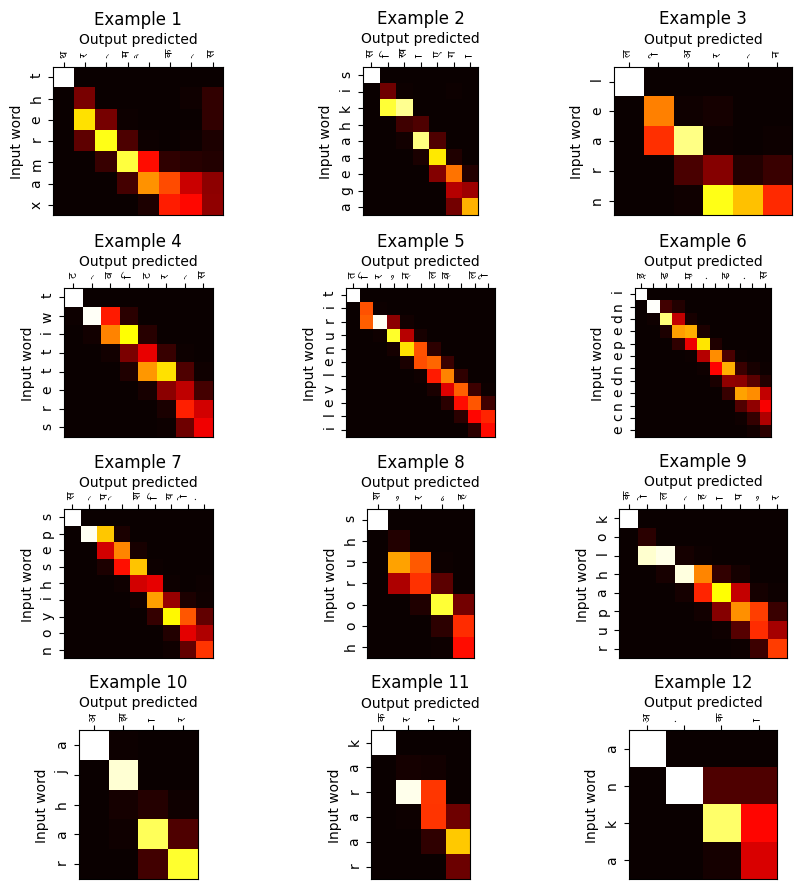

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
tel_font = FontProperties(fname = 'TiroDevanagariHindi-Regular.ttf')
# Assuming you have attention_weights of shape (batch_size, output_sequence_length, batch_size, input_sequence_length)
# and prediction_matrix of shape (batch_size, output_sequence_length)
# and input_matrix of shape (batch_size, input_sequence_length)

# Define the grid dimensions
rows = int(np.ceil(np.sqrt(12)))
cols = int(np.ceil(12 / rows))

# Create a figure and subplots
fig, axes = plt.subplots(rows, cols, figsize=(9, 9))

for i, ax in enumerate(axes.flatten()):
    if i < 12:
        prediction = [opLang.index2char[j.item()] for j in pred[i+1]]
        
        pred_word=""
        input_word=""

        for j in range(len(prediction)):
            # Ignore padding
            if(prediction[j] != '#'):
                pred_word += prediction[j]
            else : 
                break
        input_seq = [ipLang.index2char[j.item()] for j in testData[i][0]]
                    
        for j in range(len(input_seq)):
            if(input_seq[j] != '#'):
                    input_word += input_seq[j]
            else : 
                break
        attn_weights = atten_weights[i, :len(pred_word), :len(input_word)].detach().cpu().numpy()
        ax.imshow(attn_weights.T, cmap='hot', interpolation='nearest')
        ax.xaxis.set_label_position('top')
        ax.set_title(f'Example {i+1}')
        ax.set_xlabel('Output predicted')
        ax.set_ylabel('Input word')
        ax.set_xticks(np.arange(len(pred_word)))
        ax.set_xticklabels(pred_word, rotation = 90, fontproperties = tel_font,fontdict={'fontsize':8})
        ax.xaxis.tick_top()

        ax.set_yticks(np.arange(len(input_word)))
        ax.set_yticklabels(input_word, rotation=90)
        
        

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
wandb.init(project='CS6910_Assignment_3')

# Convert the matplotlib figure to an image
fig.canvas.draw()
image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

# Log the image in wandb
wandb.log({"attention_heatmaps": [wandb.Image(image)]})